# Machine Learning Final Project (Inference part)

In [ ]:
!pip install colorama

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, HuberRegressor
from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import rankdata

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
print(f'train {train.shape}, test {test.shape}')
print(f'failure 0: {train[train.failure==0].shape[0]}, failure 1: {train[train.failure==1].shape[0]}')

train (26570, 26), test (20775, 25)
failure 0: 20921, failure 1: 5649


In [3]:
data = pd.concat([train, test])
data['m3_missing'] = data['measurement_3'].isnull().astype(np.int8)
data['m4_missing'] = data['measurement_4'].isnull().astype(np.int8)
data['m5_missing'] = data['measurement_5'].isnull().astype(np.int8)
data['loading'] = np.log1p(data['loading'])

In [4]:
data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,m3_missing,m4_missing,m5_missing
0,0,A,4.395683,material_7,material_8,9,5,7,8,4,...,15.193,15.029,NaN,13.034,14.684,764.100,0.0,0,0,0
1,1,A,4.453067,material_7,material_8,9,5,14,3,3,...,11.755,14.732,15.425,14.395,15.631,682.057,0.0,0,0,0
2,2,A,4.424008,material_7,material_8,9,5,12,1,5,...,13.798,16.711,18.631,14.094,17.946,663.376,0.0,0,0,0
3,3,A,4.625659,material_7,material_8,9,5,13,2,6,...,10.020,15.250,15.562,16.154,17.172,826.282,0.0,0,0,0
4,4,A,5.242064,material_7,material_8,9,5,9,2,8,...,12.428,16.182,12.760,13.153,16.412,579.885,0.0,0,0,0


In [5]:
data = pd.concat([data, pd.get_dummies(data['attribute_0'])], axis=1)
data.rename(columns={'material_5': 'attribute_0_material_5', 'material_7': 'attribute_0_material_7'}, inplace=True)

data = pd.concat([data, pd.get_dummies(data['attribute_1'])], axis=1)
data.rename(columns={'material_5': 'attribute_1_material_5', 'material_6': 'attribute_1_material_6', 'material_7': 'attribute_1_material_7' ,'material_8': 'attribute_1_material_8'}, inplace=True)

data = data.drop(['attribute_0', 'attribute_1'], axis=1)
data.columns

Index(['id', 'product_code', 'loading', 'attribute_2', 'attribute_3',
       'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3',
       'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7',
       'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11',
       'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15',
       'measurement_16', 'measurement_17', 'failure', 'm3_missing',
       'm4_missing', 'm5_missing', 'attribute_0_material_5',
       'attribute_0_material_7', 'attribute_1_material_5',
       'attribute_1_material_6', 'attribute_1_material_7',
       'attribute_1_material_8'],
      dtype='object')

In [6]:
fill_dict = {
    'A': ['measurement_5','measurement_6','measurement_8'],
    'B': ['measurement_4','measurement_5','measurement_7'],
    'C': ['measurement_5','measurement_7','measurement_8','measurement_9'],
    'D': ['measurement_5','measurement_6','measurement_7','measurement_8'],
    'E': ['measurement_4','measurement_5','measurement_6','measurement_8'],
    'F': ['measurement_4','measurement_5','measurement_6','measurement_7'],
    'G': ['measurement_4','measurement_6','measurement_8','measurement_9'],
    'H': ['measurement_4','measurement_5','measurement_7','measurement_8','measurement_9'],
    'I': ['measurement_3','measurement_7','measurement_8']
}

feature = [f for f in test.columns if f.startswith('measurement') or f=='loading']

for code in data.product_code.unique():
    tmp = data[data.product_code==code]
    column = fill_dict[code]
    tmp_train = tmp[column+['measurement_17']].dropna(how='any')
    # print((tmp[column].isnull().sum(axis=1)==0)) # True --> 沒有缺失值 , False --> 有缺失值 （對每個row進行判斷）
    # print((tmp['measurement_17'].isnull()))  # True --> measurement_17 有缺失值, False --> 沒有缺失值
    tmp_test = tmp[(tmp[column].isnull().sum(axis=1)==0)&(tmp['measurement_17'].isnull())] # 找到measurement 5 6 8 沒缺但 measurement 17有缺的
    print(f"code {code} has {len(tmp_test)} samples to fill nan")
    model = HuberRegressor()
    model.fit(tmp_train[column], tmp_train['measurement_17'])
    data.loc[(data.product_code==code)&(data[column].isnull().sum(axis=1)==0)&(data['measurement_17'].isnull()), 'measurement_17'] = model.predict(tmp_test[column]) # 填補17的缺失值

    model2 = KNNImputer(n_neighbors=5)
    print(f"Predicting the missing values for code {code}")
    data.loc[data.product_code==code, feature] = model2.fit_transform(data.loc[data.product_code==code, feature]) # predict the missing values in a dataset!

code A has 386 samples to fill nan
Predicting the missing values for code A
code B has 418 samples to fill nan
Predicting the missing values for code B
code C has 391 samples to fill nan
Predicting the missing values for code C
code D has 398 samples to fill nan
Predicting the missing values for code D
code E has 429 samples to fill nan
Predicting the missing values for code E
code F has 420 samples to fill nan
Predicting the missing values for code F
code G has 373 samples to fill nan
Predicting the missing values for code G
code H has 361 samples to fill nan
Predicting the missing values for code H
code I has 377 samples to fill nan
Predicting the missing values for code I


In [7]:
def _scale(train_data, val_data, test_data, feats):
    scaler = StandardScaler()
    
    scaled_train = scaler.fit_transform(train_data[feats]) # fit + transform
    scaled_val = scaler.transform(val_data[feats]) # only transform
    scaled_test = scaler.transform(test_data[feats]) # only transform
    
    #back to dataframe
    new_train = train_data.copy()
    new_val = val_data.copy()
    new_test = test_data.copy()
    
    new_train[feats] = scaled_train
    new_val[feats] = scaled_val
    new_test[feats] = scaled_test
    
    assert len(train_data) == len(new_train)
    assert len(val_data) == len(new_val)
    assert len(test_data) == len(new_test)
    
    return new_train, new_val, new_test

In [8]:
train = data[data.failure.notnull()]
test = data[data.failure.isnull()]
print(train.shape, test.shape)

(26570, 33) (20775, 33)


In [9]:
X = train.drop(['failure'], axis=1)
y = train['failure'].astype(int)
test = test.drop(['failure'], axis=1)

#### Three combinations of features

In [10]:
select_feature_1 = ['loading', 'measurement_17', 'measurement_2', 'm3_missing','m5_missing', 'measurement_4', 'attribute_0_material_5', 'attribute_0_material_7','m4_missing']
select_feature_2 = ['measurement_1', 'measurement_2', 'loading', 'measurement_17']
select_feature_3 = ['m3_missing', 'm5_missing', 'measurement_2', 'loading', 'measurement_17']
select_feature = [select_feature_1, select_feature_2, select_feature_3]

#### Training Process and Inference

Training with feature ['loading', 'measurement_17', 'measurement_2', 'm3_missing', 'm5_missing', 'measurement_4', 'attribute_0_material_5', 'attribute_0_material_7', 'm4_missing']
Average auc = 0.59202, Average acc = 0.78739
OOF auc = 0.59189, OOF acc = 0.78739


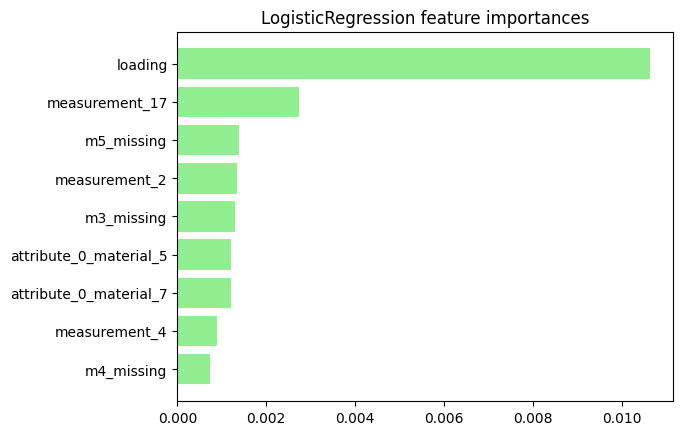

Training with feature ['measurement_1', 'measurement_2', 'loading', 'measurement_17']
Average auc = 0.59031, Average acc = 0.78739
OOF auc = 0.5902, OOF acc = 0.78739


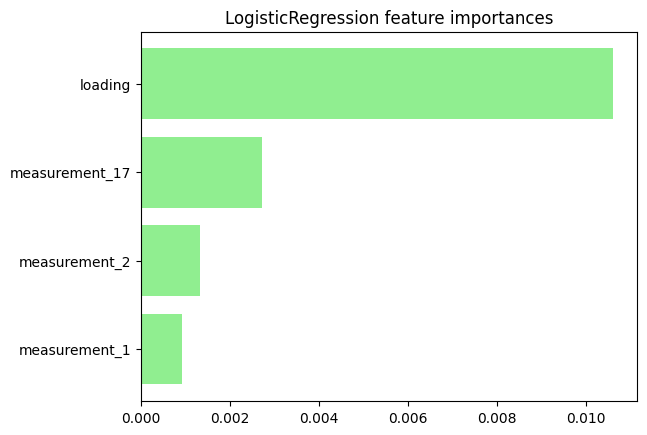

Training with feature ['m3_missing', 'm5_missing', 'measurement_2', 'loading', 'measurement_17']
Average auc = 0.59093, Average acc = 0.78739
OOF auc = 0.59083, OOF acc = 0.78739


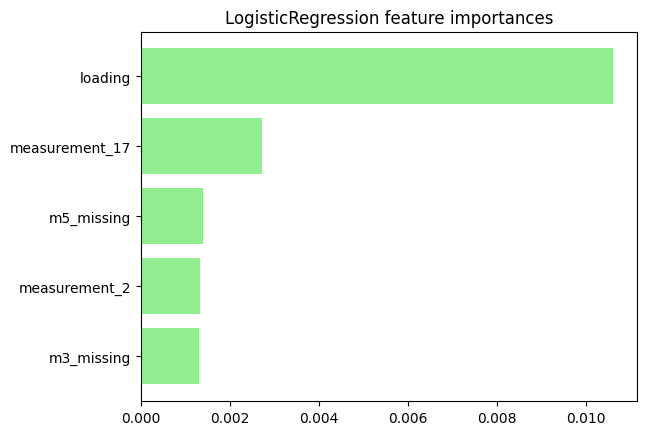

In [11]:
lr_test_data = []

for i in range(3):
    print(f"Training with feature {select_feature[i]}")
    lr_oof_1 = np.zeros(len(train))
    lr_oof_2 = np.zeros(len(train))
    lr_test = np.zeros(len(test))
    lr_auc = 0
    lr_acc = 0
    importance_list = []

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        x_test = test.copy()
        
        x_train, x_val, x_test = _scale(x_train, x_val, x_test, select_feature[i])
        
        model = LogisticRegression(max_iter=1000, C=1e-5, penalty='l2', solver='newton-cg') # , class_weight='balanced'
        model.fit(x_train[select_feature[i]], y_train)
        importance_list.append(model.coef_.ravel())

        val_preds = model.predict_proba(x_val[select_feature[i]])[:, 1]
        lr_auc += roc_auc_score(y_val, val_preds) / 5
        y_preds = model.predict(x_val[select_feature[i]])
        lr_acc += accuracy_score(y_val, y_preds) / 5
        lr_test += model.predict_proba(x_test[select_feature[i]])[:, 1] / 5
        lr_oof_1[val_idx] = val_preds
        lr_oof_2[val_idx] = y_preds

    lr_test_data.append(lr_test)
    print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
    print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(y, lr_oof_1), 5)}, OOF acc = {round(accuracy_score(y, lr_oof_2), 5)}{Style.RESET_ALL}")

    importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature[i]].columns)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = x_train[select_feature[i]].columns
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
    plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title('LogisticRegression feature importances')
    plt.show()

In [12]:
submission['lr0'] = lr_test_data[0]
submission['lr1'] = lr_test_data[1]
submission['lr2'] = lr_test_data[2]

### Generate submission.csv

In [13]:
submission['rank0'] = rankdata(submission['lr0'])
submission['rank1'] = rankdata(submission['lr1'])
submission['rank2'] = rankdata(submission['lr2'])

# Ensemble the three models
submission['failure'] = submission['rank0']*0.4 + submission['rank1']*0.3 + submission['rank2']*0.3

# Generate submission.csv
submission[['id', 'failure']].to_csv('0713332_final_submission.csv', index=False)

# head
submission.head()

,id,failure,lr0,lr1,lr2,rank0,rank1,rank2
0,26570,8253.1,0.211587,0.212173,0.212190,7573.0,8719.0,8694.0
1,26571,4033.6,0.210250,0.211136,0.211116,3118.0,4697.0,4591.0
2,26572,6372.5,0.211115,0.211639,0.211764,5810.0,6502.0,6993.0
3,26573,7065.1,0.211252,0.211867,0.211956,6292.0,7433.0,7728.0
4,26574,19864.6,0.215301,0.216015,0.216289,19435.0,20084.0,20218.0


### My Ensemble models' selected features

```
model_1_select_feature = ['loading', 'measurement_17', 'measurement_2', 'm3_missing','m5_missing', 'measurement_4', 'attribute_0_material_5', 'attribute_0_material_7','m4_missing']
model_2_select_feature = ['measurement_1', 'measurement_2', 'loading', 'measurement_17']
model_3_select_feature = ['m3_missing', 'm5_missing', 'measurement_2', 'loading', 'measurement_17']
```